# Potential flow and Joukowski transform

Philipp Schlatter, 2024 (adapted from Barba et al. Aeropython)

In [1]:
import math as mt
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
# embed the figures into the notebook
%matplotlib notebook

In [2]:
#x_center, y_center = -0.0, 0.          # line
x_center, y_center = -0.08, 0.08          # cambered airfoil
#x_center,y_center = -0.08,0              # symmetric profile


u_inf = 1             # free-stream speed
alpha = 15*mt.pi/180  # angle of attack


R=np.sqrt((1-x_center)**2+y_center**2)   # circle needs to go through (1,0)
M = (R**2)*2*mt.pi*u_inf  # doublet for circle with radius R
Gamma = -4*mt.pi*R*u_inf*np.sin(alpha)  # Kutta condition for AoA alpha

In [3]:
class Cartesian:
    def __init__(self,N,x_start,x_end,y_start,y_end):
        self.X, self.Y = np.meshgrid(np.linspace(x_start, x_end, N), np.linspace(y_start, y_end, N))
        self.type = "Cartesian"
        
class Polar:
    def __init__(self,N,r_start,r_end):
        xx,yy = np.meshgrid(np.linspace(r_start,r_end,N),np.linspace(0,2*mt.pi,N,endpoint=True))
        self.X, self.Y = xx*np.cos(yy)+x_center,xx*np.sin(yy)+y_center
        self.type = "Polar"
        
class Velocity:
    def __init__(self,mesh):
        self.u = mesh.X*0
        self.v = mesh.X*0
        self.p = mesh.X*0
        
    def comp_p(self,u_ref):
        self.p = 2*(0.5*u_ref**2-0.5*(self.u**2 + self.v**2))

In [4]:
# for a Kutta-Joukoswski airfoil, we choose a polar mesh
mesh = Polar(150,R,8)

In [5]:
class Doublet:
    # strength M
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y
        
    def vel(self, mesh):
        u = (-self.strength / (2 * mt.pi) *
             ((mesh.X - self.x)**2 - (mesh.Y - self.y)**2) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        v = (-self.strength / (2 * mt.pi) *
             2 * (mesh.X - self.x) * (mesh.Y - self.y) /
             ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)**2)
        return u, v
            
    def psi(self, mesh):
        psi = (self.strength / (2 * mt.pi) *
               (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return psi

In [6]:
class Vortex:
    def __init__(self, strength, x, y):
        self.strength = strength
        self.x, self.y = x, y
    
    def vel(self, mesh):
        u = -self.strength / (2 * mt.pi) * (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        v = +self.strength / (2 * mt.pi) * (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return u, v
    
    def psi(self, mesh):
        psi =  self.strength / (4 * mt.pi) * np.log((mesh.X - self.x)**2 + (mesh.Y - self.y)**2)
        return psi

In [7]:
class Source:
    # m=Q/2pi
    def __init__(self, strength, x, y):
        self.strength = strength  # Q
        self.x, self.y = x, y
    
    def vel(self, mesh):
        u = (self.strength / (2 * mt.pi) *
             (mesh.X - self.x) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        v = (self.strength / (2 * mt.pi) *
             (mesh.Y - self.y) / ((mesh.X - self.x)**2 + (mesh.Y - self.y)**2))
        return u, v
    
    def psi(self, mesh):
        psi = -(self.strength / (2 * mt.pi) *
               numpy.arctan2((mesh.Y - self.y), (mesh.X - self.x)))
        return psi

In [8]:
class Freestream:
    def __init__(self, strength, alpha):
        self.strength = strength
        self.alpha = alpha
        
    def vel(self, mesh):
        u = mesh.X*0 + self.strength*np.cos(self.alpha) 
        v = mesh.X*0 + self.strength*np.sin(self.alpha) 
        return u, v
            
    def psi(self, mesh):
        psi = self.strength*(mesh.X*np.sin(self.alpha) - mesh.Y*np.cos(self.alpha))
        return psi

In [9]:
# Flow around a cylinder
fst = Freestream(u_inf,0)
u1,v1 = fst.vel(mesh)
psi1 = fst.psi(mesh)

doublet = Doublet(strength=M, x=x_center,y=y_center)
u2, v2 = doublet.vel(mesh)
psi2 = doublet.psi(mesh)

vortex = Vortex(strength=Gamma, x=x_center,y=y_center)
u3, v3 = vortex.vel(mesh)
psi3 = vortex.psi(mesh)

U = Velocity(mesh)
U.u = u1+u2+u3
U.v = v1+v2+v3
psi = psi1+psi2+psi3

#R = np.sqrt(M/(2*mt.pi*u_inf))

theta = np.linspace(0.0, 2 * mt.pi, 100)
x_cylinder, y_cylinder = (x_center + R * np.cos(theta),
                          y_center + R * np.sin(theta))

<IPython.core.display.Javascript object>


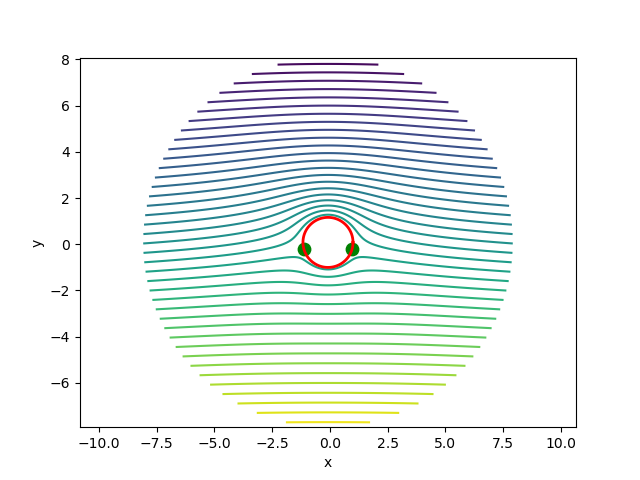

In [10]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.contour(mesh.X, mesh.Y, psi,40)
plt.plot(x_cylinder, y_cylinder, color='r', linestyle='-', linewidth=2)
if (np.abs(Gamma)>4*mt.pi*R*u_inf):
    x_stagn1, y_stagn1 = 0,1/(4*mt.pi*u_inf)*(Gamma-np.sqrt(Gamma**2-(4*mt.pi*R*u_inf)**2))
    x_stagn2, y_stagn2 = 0,1/(4*mt.pi*u_inf)*(Gamma+np.sqrt(Gamma**2-(4*mt.pi*R*u_inf)**2))
else:
    x_stagn1, y_stagn1 = ((+mt.sqrt(R**2 - (Gamma / (4 * mt.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * mt.pi * u_inf))+y_center)
    x_stagn2, y_stagn2 = ((-mt.sqrt(R**2 - (Gamma / (4 * mt.pi * u_inf))**2)+x_center),
                      +(Gamma / (4 * mt.pi * u_inf))+y_center)
plt.scatter([x_stagn1, x_stagn2], [y_stagn1, y_stagn2],
               color='g', s=80, marker='o');
plt.show()

<IPython.core.display.Javascript object>


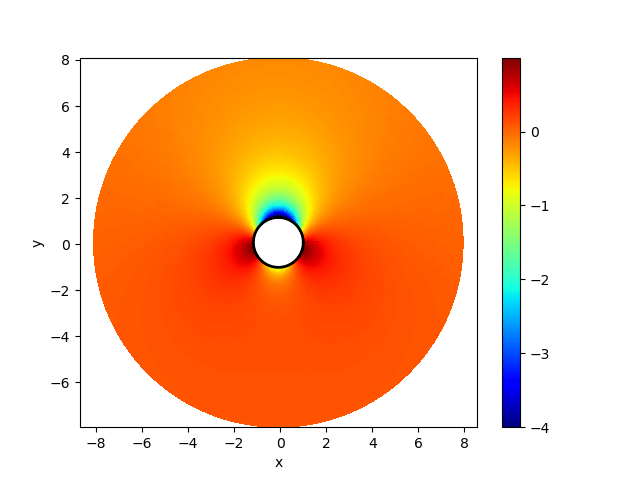

C:\Users\pschl\AppData\Local\Temp\ipykernel_20616\1251752603.py:5: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(mesh.X, mesh.Y, U.p,vmin=-4,cmap='jet')


In [11]:
U.comp_p(u_inf)
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(mesh.X, mesh.Y, U.p,vmin=-4,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(x_cylinder, y_cylinder, color='k', linestyle='-', linewidth=2)
plt.show()

In [12]:
alpha = np.arcsin(-Gamma/(4*mt.pi*R*u_inf))
xi = (mesh.X + 1j*mesh.Y - (x_center+1j*y_center))*np.exp(1j*alpha) +  (x_center+1j*y_center)
xi_cyl = (x_cylinder + 1j*y_cylinder - (x_center+1j*y_center))*np.exp(1j*alpha)+  (x_center+1j*y_center)

In [13]:
Z = (1/xi + xi)*np.exp(-1j*alpha)
Z_cyl = (1/xi_cyl + xi_cyl)*np.exp(-1j*alpha)

<IPython.core.display.Javascript object>


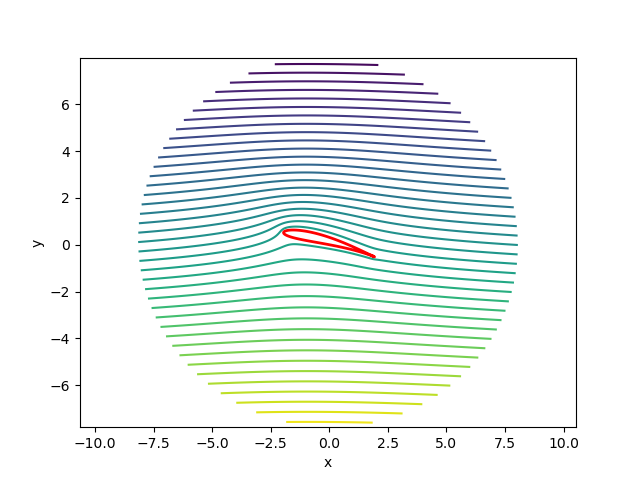

In [14]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.contour(np.real(Z), np.imag(Z), psi,40)
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='r', linestyle='-', linewidth=2)
plt.show()

<IPython.core.display.Javascript object>


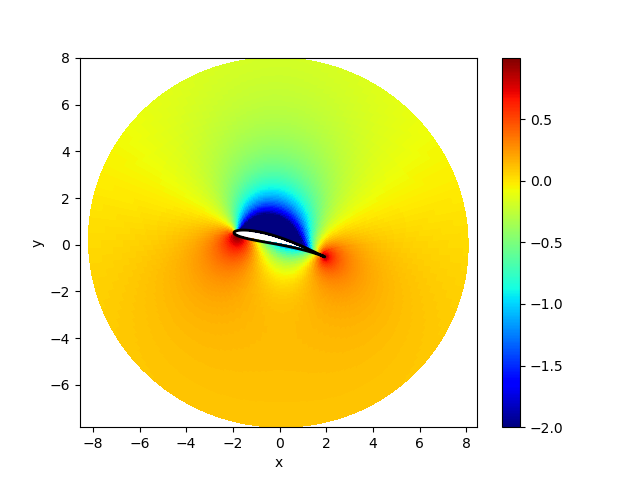

C:\Users\pschl\AppData\Local\Temp\ipykernel_20616\526558234.py:4: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(np.real(Z),np.imag(Z), U.p,vmin=-2,cmap='jet')


In [15]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.pcolor(np.real(Z),np.imag(Z), U.p,vmin=-2,cmap='jet')
plt.axis('equal')
plt.colorbar()
plt.plot(np.real(Z_cyl), np.imag(Z_cyl), color='k', linestyle='-', linewidth=2)
plt.show()

<IPython.core.display.Javascript object>


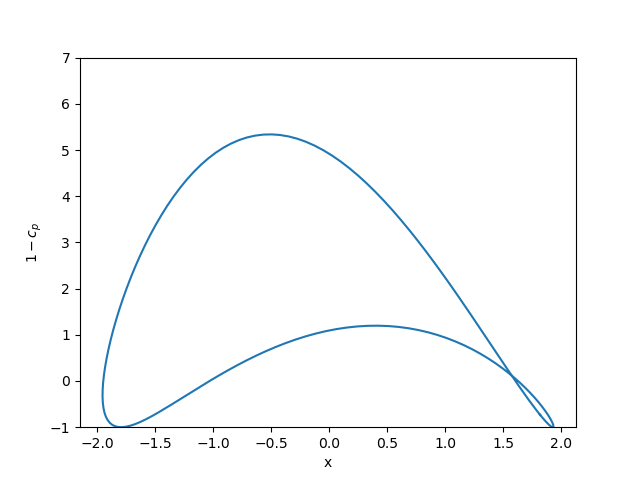

In [16]:
plt.figure()
plt.plot(np.real(Z[:,0]),-U.p[:,0])
plt.xlabel('x')
plt.ylabel(r'$1-c_p$')
plt.ylim(-1,7)
plt.show()

In [17]:
# Lift coefficient C_L:
c = 4  # approximation for Joukowski profiles
-2*Gamma/u_inf/c

1.7611164657336387

Lift per unit span: $L/b = -\rho \Gamma U_\infty$

Lift coefficient: $C_L = L/(\frac12 \rho U_\infty^2 c b) = -2  \Gamma / (U_\infty c) =  8\pi\sin(\alpha) (R/c) \approx 2 \pi \sin(\alpha)$

Lift slope: $\frac{\mathrm d C_L}{\mathrm d \alpha} = 2\pi$

In [18]:
2*np.pi*np.sin(alpha)

1.626208021406409